<a href="https://colab.research.google.com/github/basselkassem/covid19/blob/master/eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install libs

In [0]:
import json
access_token = {"username":"","key":""}
with open('/content/kaggle.json', 'w') as file:
    json.dump(access_token, file)
!pip install -q kaggle
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c covid19-global-forecasting-week-3

test.csv: Skipping, found more recently modified local copy (use --force to force download)
submission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!pip install geopandas

In [0]:
!pip install 'folium==0.10.1'

     |████████████████████████████████| 92kB 3.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.10.1 which is incompatible.
  Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3


# Import Libs

In [0]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import folium
import geopandas as gpd
import requests
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

mpl.rcParams['axes.grid']=True
print(folium.__version__)

0.8.3


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

# Utile Functions

In [0]:
def display_df_info(df, name):
    print('-----------Shape of '+ name + '-------------')
    print(df.shape)
    print('-----------Missing values---------')
    print(df.isnull().sum())
    print('-----------Null values------------')
    print(df.isna().sum())
    print('-----------Data types-------------')
    print(df.dtypes)
    print('-----------Memory usage (MB)------')
    print(np.round(df.memory_usage(deep = True).sum() / 1024**2, 2))
  
def plot_country(df, country):
  country_df = df[df['Country_Region'] == country]
  fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 5))
  axes[0].set_xlim(country_df.Date.min(), country_df.Date.max())
  axes[0].set_title(country + ' Falaities')
  axes[1].set_xlim(country_df.Date.min(), country_df.Date.max())
  axes[1].set_title(country + ' Confirmed Cases')
  sns.lineplot(x = 'Date', y = 'Fatalities', data = country_df, ax = axes[0])
  sns.lineplot(x = 'Date', y = 'ConfirmedCases', data = country_df, ax = axes[1])
  plt.show()

def get_gepoint(country_name):
  try:
    location = geolocator.geocode(country_name)
    lat = location.raw['lat']
    lon = location.raw['lon']
    geo_point = lat + ',' + lon
    return geo_point
  except Exception:
    return get_gepoint(country_name)

def get_address(geo_point):
  try:
    return geolocator.reverse(geo_point, addressdetails = True)
  except Exception:
    return get_address(geo_point)

def find_country_code(country_name):
  geo_point = get_gepoint(country_name)
  location  = get_address(geo_point)
  if 'error' in location.raw:
    return 'None'
  if 'address' in location.raw:
    if 'country_code' in location.raw['address']:
      return location.raw['address']['country_code']
  return 'None'

def create_country_code(row, colname):
  code = find_country_code(row[colname])
  row['country_code'] = code
  return row

# Train set

In [0]:
display_df_info(train, 'train')

-----------Shape of train-------------
(23562, 6)
-----------Missing values---------
Id                    0
Province_State    13552
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64
-----------Null values------------
Id                    0
Province_State    13552
Country_Region        0
Date                  0
ConfirmedCases        0
Fatalities            0
dtype: int64
-----------Data types-------------
Id                  int64
Province_State     object
Country_Region     object
Date               object
ConfirmedCases    float64
Fatalities        float64
dtype: object
-----------Memory usage (MB)------
4.53


In [0]:
train.Date = pd.to_datetime(train.Date)

In [0]:
train.describe(include = 'all')

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
count,23562.000000,10010,23562,23562,23562.000000,23562.000000
unique,NaN,130,180,77,NaN,NaN
top,NaN,Martinique,US,2020-01-25 00:00:00,NaN,NaN
freq,NaN,77,4158,306,NaN,NaN
first,NaN,NaN,NaN,2020-01-22 00:00:00,NaN,NaN
last,NaN,NaN,NaN,2020-04-07 00:00:00,NaN,NaN
mean,16356.500000,NaN,NaN,NaN,801.323275,37.467617
std,9451.977497,NaN,NaN,NaN,6312.495888,468.699337
min,1.000000,NaN,NaN,NaN,0.000000,0.000000
25%,8171.250000,NaN,NaN,NaN,0.000000,0.000000


## find duplicates

In [0]:
print('number of duplicates:', len(train[train.duplicated()]))

number of duplicates: 0


##Outliers

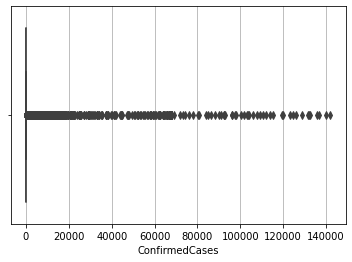

In [0]:
sns.boxplot(x = train['ConfirmedCases'] )
plt.show()

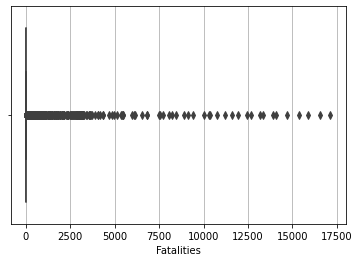

In [0]:
sns.boxplot(x = train['Fatalities'])
plt.show()

# Display Confirmed cases and fatalites

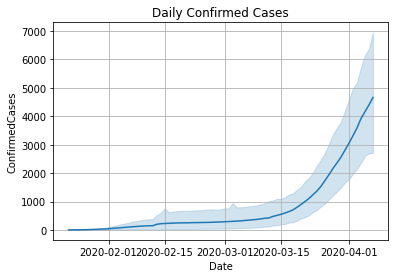

In [0]:
sns.lineplot(x = 'Date', y = 'ConfirmedCases', data = train)
plt.title('Daily Confirmed Cases')
plt.show()

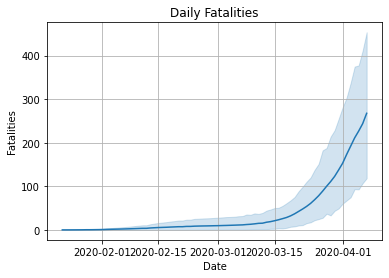

In [0]:
sns.lineplot(x = 'Date', y = 'Fatalities', data = train)
plt.title('Daily Fatalities')
plt.show()

In [0]:
df = train.groupby(by = 'Date').sum()
df = df.drop(columns=['Id'])

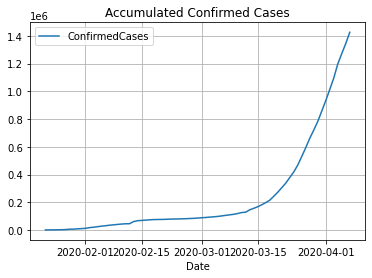

In [0]:
sns.lineplot(data = df[['ConfirmedCases']])
plt.title('Accumulated Confirmed Cases')
plt.show()

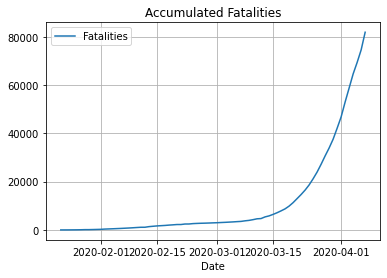

In [0]:
sns.lineplot(data = df[['Fatalities']])
plt.title('Accumulated Fatalities')
plt.show()

# Display Confirmed cases and fatalites for each country

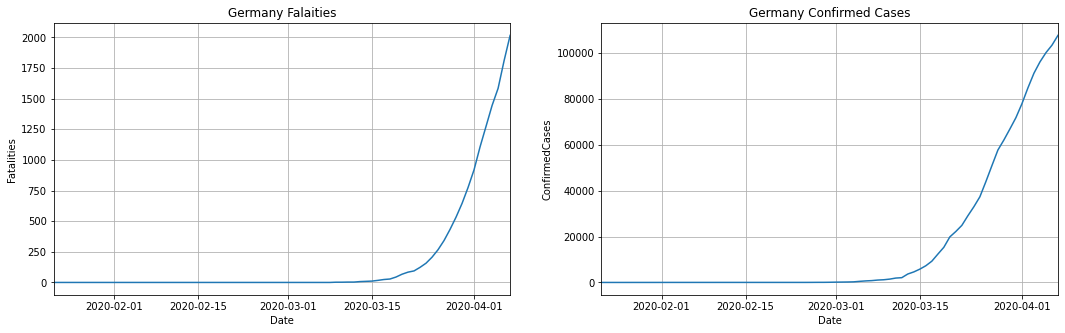

In [0]:
country = 'Germany'
plot_country(train, country)

In [0]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
country_shapes = f'{url}/world-countries.json'
geo_countries = gpd.GeoDataFrame.from_features(requests.get(country_shapes).json())
print(geo_countries.shape)
geo_countries.head()

(177, 2)


,geometry,name
0,"POLYGON ((61.21082 35.65007, 62.23065 35.27066...",Afghanistan
1,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6...",Angola
2,"POLYGON ((20.59025 41.85540, 20.46317 41.51509...",Albania
3,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",United Arab Emirates
4,"MULTIPOLYGON (((-65.50000 -55.20000, -66.45000...",Argentina


In [0]:
geo_countries['country_code'] = 'None'
geo_countries = geo_countries.apply(create_country_code, colname = 'name', axis = 1)

In [0]:
print(geo_countries.shape)
print(geo_countries[geo_countries['country_code'] == 'None'].shape)
geo_countries[geo_countries['country_code'] == 'None'].head()

(177, 3)
(2, 3)


,geometry,name,country_code
6,"MULTIPOLYGON (((-59.57209 -80.04018, -59.86585...",Antarctica,None
141,"MULTIPOLYGON (((162.11902 -10.48272, 162.39865...",Solomon Islands,None


In [0]:
from google.colab import drive
drive.mount('/content/drive/')
data_path = '/content/drive/My Drive/Colab Notebooks/covid19/data/'
geo_countries.to_pickle(data_path + 'geo_countries.pkl')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
df = train[train['Date'] == train['Date'].max()]
df = df.groupby(by = 'Country_Region').sum()
df = df.drop(columns = 'Id')
df = df.reset_index()
print(df.shape)
df['country_code'] = 'None'
df = df.apply(create_country_code, colname = 'Country_Region', axis = 1)
print(df.shape)
df.head()

(180, 3)
(180, 4)


,Country_Region,ConfirmedCases,Fatalities,country_code
0,Afghanistan,367.0,11.0,af
1,Albania,377.0,21.0,al
2,Algeria,1423.0,173.0,dz
3,Andorra,525.0,21.0,ad
4,Angola,16.0,2.0,ao


In [0]:
print(df.shape)
print(df[df['country_code'] == 'None'].shape)
df[df['country_code'] == 'None']

(180, 4)
(0, 4)


,Country_Region,ConfirmedCases,Fatalities,country_code


In [0]:
df.to_pickle(data_path + 'train.pkl')

In [0]:
gf = df.merge(geo_countries, how = 'inner', on = 'country_code')
print(gf.shape)
print(gf[gf['country_code'] == 'None'].shape)
gf[gf['country_code'] == 'None']
gf = gpd.GeoDataFrame(gf)
gf.crs = {'init' :'epsg:4326'}

(174, 6)
(0, 6)


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [0]:
from folium.features import GeoJson, GeoJsonTooltip
import branca
m = folium.Map()
colormap = branca.colormap.LinearColormap(vmin=gf['ConfirmedCases'].min(), 
                                        vmax=gf['ConfirmedCases'].max(), 
                                        colors=['green', 'yellow', 'red'],
                                        index=[1,50000, 120000],
                                       caption="ConfirmedCases")
tooltip=GeoJsonTooltip(
    fields=["Country_Region", "ConfirmedCases", "Fatalities"],
    aliases=["Country_Region:", "ConfirmedCases", "Fatalities"],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 2px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """,
)


g = folium.GeoJson(
    gf,
    style_function = lambda x: {
        "fillColor": colormap(x["properties"]["ConfirmedCases"])
        if x["properties"]["ConfirmedCases"] is not None
        else "transparent",
        "color": "black",
        "fillOpacity": 0.9,
    },
    tooltip=tooltip,
).add_to(m)

colormap.add_to(m)

m


# Test set

In [0]:
test.Date = pd.to_datetime(test.Date)
display_df_info(test, 'test')

-----------Shape of test-------------
(13158, 4)
-----------Missing values---------
ForecastId           0
Province_State    7568
Country_Region       0
Date                 0
dtype: int64
-----------Null values------------
ForecastId           0
Province_State    7568
Country_Region       0
Date                 0
dtype: int64
-----------Data types-------------
ForecastId                 int64
Province_State            object
Country_Region            object
Date              datetime64[ns]
dtype: object
-----------Memory usage (MB)------
1.59


In [0]:
print('train start date', train.Date.min())
print('train end date', train.Date.max())
print('test start date', test.Date.min())
print('test end date', test.Date.max())

print('test and train overlap:', train.Date.max()- test.Date.min())

train start date 2020-01-22 00:00:00
train end date 2020-04-07 00:00:00
test start date 2020-03-26 00:00:00
test end date 2020-05-07 00:00:00
test and train overlap: 12 days 00:00:00


#Fill Missing values

In [0]:
countries_province = train[~train['Province_State'].isna()]
countries = countries_province['Country_Region'].unique()
print(len(countries), 'countries with province state:', countries)

8 countries with province state: ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


In [0]:
for country in countries:
  states = train[train['Country_Region'] == country].Province_State.unique()
  print(country,  ' has ', len(states), 'states:', states)
  print('-----')

Australia  has  8 states: ['Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia']
-----
Canada  has  12 states: ['Alberta' 'British Columbia' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Northwest Territories' 'Nova Scotia'
 'Ontario' 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Yukon']
-----
China  has  33 states: ['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
-----
Denmark  has  3 states: ['Faroe Islands' 'Greenland' nan]
-----
France  has  10 states: ['French Guiana' 'French Polynesia' 'Guadeloupe' 'Martinique' 'Mayotte'
 'New Caledonia' 'Reunion' 'Saint Barthelemy' 'St Martin' nan]
-----
Nether

In [0]:
countries_province = test[~test['Province_State'].isna()]
countries = countries_province['Country_Region'].unique()
print(len(countries), 'countries with province state in test set:', countries)

8 countries with province state in test set: ['Australia' 'Canada' 'China' 'Denmark' 'France' 'Netherlands' 'US'
 'United Kingdom']


In [0]:
for country in countries:
  states = test[test['Country_Region'] == country].Province_State.unique()
  print(country,  'has', len(states), 'states:', states)
  print('-----')

Australia has 8 states: ['Australian Capital Territory' 'New South Wales' 'Northern Territory'
 'Queensland' 'South Australia' 'Tasmania' 'Victoria' 'Western Australia']
-----
Canada has 12 states: ['Alberta' 'British Columbia' 'Manitoba' 'New Brunswick'
 'Newfoundland and Labrador' 'Northwest Territories' 'Nova Scotia'
 'Ontario' 'Prince Edward Island' 'Quebec' 'Saskatchewan' 'Yukon']
-----
China has 33 states: ['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
-----
Denmark has 3 states: ['Faroe Islands' 'Greenland' nan]
-----
France has 10 states: ['French Guiana' 'French Polynesia' 'Guadeloupe' 'Martinique' 'Mayotte'
 'New Caledonia' 'Reunion' 'Saint Barthelemy' 'St Martin' nan]
-----
Netherlands has 

In [0]:
france = train[train['Country_Region'] == 'France']
france[france['Province_State'].isna()].head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
9394,13055,NaN,France,2020-01-22,0.0,0.0
9395,13056,NaN,France,2020-01-23,0.0,0.0
9396,13057,NaN,France,2020-01-24,2.0,0.0
9397,13058,NaN,France,2020-01-25,3.0,0.0
9398,13059,NaN,France,2020-01-26,3.0,0.0


## Fill missing province state with the name of the country

In [0]:
def fill_province(row):
  if pd.isna(row['Province_State']):
    row['Province_State'] = row['Country_Region'] + '_state'
  return row

df = train.apply(fill_province, axis = 1)
df_test = test.apply(fill_province, axis = 1)

In [0]:
df.isna().sum()

Id                0
Province_State    0
Country_Region    0
Date              0
ConfirmedCases    0
Fatalities        0
dtype: int64

In [0]:
france = df[df['Country_Region'] == 'France']
france['Province_State'].unique()

array(['French Guiana', 'French Polynesia', 'Guadeloupe', 'Martinique',
       'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy',
       'St Martin', 'France_state'], dtype=object)

In [0]:
df_test.isna().sum()

ForecastId        0
Province_State    0
Country_Region    0
Date              0
dtype: int64

In [0]:
france = df_test[df_test['Country_Region'] == 'France']
france['Province_State'].unique()

array(['French Guiana', 'French Polynesia', 'Guadeloupe', 'Martinique',
       'Mayotte', 'New Caledonia', 'Reunion', 'Saint Barthelemy',
       'St Martin', 'France_state'], dtype=object)

In [0]:
df

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,Afghanistan_state,Afghanistan,2020-01-22,0.0,0.0
1,2,Afghanistan_state,Afghanistan,2020-01-23,0.0,0.0
2,3,Afghanistan_state,Afghanistan,2020-01-24,0.0,0.0
3,4,Afghanistan_state,Afghanistan,2020-01-25,0.0,0.0
4,5,Afghanistan_state,Afghanistan,2020-01-26,0.0,0.0
...,...,...,...,...,...,...
23557,32708,Zimbabwe_state,Zimbabwe,2020-04-03,9.0,1.0
23558,32709,Zimbabwe_state,Zimbabwe,2020-04-04,9.0,1.0
23559,32710,Zimbabwe_state,Zimbabwe,2020-04-05,9.0,1.0
23560,32711,Zimbabwe_state,Zimbabwe,2020-04-06,10.0,1.0



There are 8 countries with states. The rest of the countries, the states are not provided. One solution could be to fill those missing values with a default value. This could cause overfitting, because we are not adding new information.

Another solution is to ignore this attribute for the countries that don't have it. Build Tow models; one for the 8 countries, and another for the rest.